# Class 8 - Support Vector Machines (SVM)

Support Vector Machines are one of the most used and versatile Machine Learning algorithms. Originally SVM were invented to solve the problem of finding high-margin hyperplanes for linearly separating datapoints.

Nowadays SVMs have been substantially improved and can be used to solve efficiently both linear and highly non-linear classification problems.

In this class we will focus on the linear implementation of SVM, applied to binary classification problems.

## The Perceptron

The problem we want to tackle is that of binary classication with $\mathcal{X} = \mathbb{R}^d$ and $\mathcal{Y} = \{-1, +1\}$. In particular we imagine that the points in our dataset form two separate clusters in the space $\mathcal{X}$ and we look for an hyperplane that separates them. 

Our hypothesis class is therefore the class of halfspaces in $d$ dimensions:

$$ \mathcal{F} = \{x\mapsto \text{sign}(\langle w,x \rangle + b) \;\vert\; w∈ℝ^{d}, b \in \mathbb{R}\}$$

Let us specialize to the case $d=2$ and look at an artificially generated dataset.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

%matplotlib inline

x, y = datasets.make_blobs(n_samples=200, centers=[[8,8],[10,10]], n_features=2, cluster_std=0.5, random_state=4)
y = 2*y-1

plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

We can find the right separator by iteratively moving in the direction of mislabeled points, using the following algorithm, which can be proved to converge in the case of linearly separable data.

$\quad \quad \quad$ **(Batch) Perceptron algorithm**:

**Input**: Training dataset $(x_1, y_1), \ldots, (x_n, y_n)$.

**Initialize**: Extend $x \to (1, x)$ and set $w^{(1)} = (0, \ldots, 0)$.

**for** $t = 1, 2, 3, \ldots$:

$\quad$ **if** $\:\: \exists i \:\: \text{s.t} \:\: y_i\langle w, x_i \rangle \le 0$:

$\quad \quad$ $w^{(t+1)} = w^{(t)} + y_i x_i$

$\quad$ **else**:

$\quad \quad$ **return** $w^{(t)}$

In [ ]:
def addones(x):
    column_of_ones = np.ones((x.shape[0],1))
    output = np.hstack((column_of_ones,x))
    return output

def perceptron_train(x, y):
    n,d = x.shape
    w = np.zeros(d)
    mislabeled = x.dot(w)*y <= 0
    while any(mislabeled):
        mislabeled_index = np.where(mislabeled==True)[0][0]
        w = w + y[mislabeled_index]*x[mislabeled_index,:]
        mislabeled = x.dot(w)*y <= 0
    return w

In [ ]:
t = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 10)

w = perceptron_train(addones(x),y)

plt.scatter(x[:,0], x[:,1], c=y)
plt.plot(t, -(w[1]/w[2])*t-(w[0]/w[2]), 'r')
plt.show()

## Hard-margin SVM

In [ ]:
t = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 10)

plt.scatter(x[:,0], x[:,1], c=y)
plt.plot(t, -(w[1]/w[2])*t-(w[0]/w[2]), 'r')
new_x_1 = 9.8
new_x_2 = -(w[1]/w[2])*new_x_1-(w[0]/w[2]) - 0.1
plt.scatter(new_x_1, new_x_2, c='g')
plt.show()

If we were to receive a new sample point to classify (see the green dot just below the red line in the picture above), the perceptron would classify it as blue, while intuitively we can see that it should be classified as yellow with high probability.

The above separation line is very unlikely to generalize well, because it is too close to the yellow blob. 

Therefore we want to modify the algorithm of the perceptron in such a way that the chosen separation line is somehow "equally distanced" from the two blobs. In other words, we are looking for a **large margin separator**.

We want to maximize the minimum distance of any point in the dataset from the separating line, subject to the constraint that the separating line classifies the points correctly.

Notice that:
+ we can express the distance of a point $x_i$ from our line as $\frac{1}{\|w\|}|\langle w, x_i \rangle + b|$, 
+ a point is correctly classified if and only if $y_i(\langle w, x_i \rangle + b) > 0$.

Therefore, we want to solve the following optimization problem:

$$ \underset{(w,b)}{\text{argmax}} \underset{i \in [n]}{\min} \frac{1}{\|w\|} |\langle w, x_i \rangle + b| \quad \quad \text{subject to} \quad y_i(\langle w, x_i \rangle + b) > 0, \: \forall i \in [n]$$

Stated in this way, the problem is not easily solvable because the expression for the margin is quite complicated, but we can switch to an equivalent (and easier) problem.

Imagine that we have found a line, with coefficients $(\hat{w},\hat{b})$, that satisfies the optimization problem above, so that, in particular, we have that $y_i(\langle \hat{w}, x_i \rangle + \hat{b}) > 0, \: \forall i \in [n]$.

Then $y_i(\langle \hat{w}, x_i \rangle + \hat{b}) \ge \gamma$, for some $\gamma > 0$, and $y_i(\langle \frac{\hat{w}}{\gamma}, x_i \rangle + \frac{\hat{b}}{\gamma}) \ge 1$. 

Therefore, if a line $(\hat{w},\hat{b})$ correctly classifies the points, we can always rescale our space and find another line, $(w, b) = (\frac{\hat{w}}{\gamma},\frac{\hat{b}}{\gamma})$, which also correctly classifies the points. We do this because computing the margin for this rescaled line is much easier.

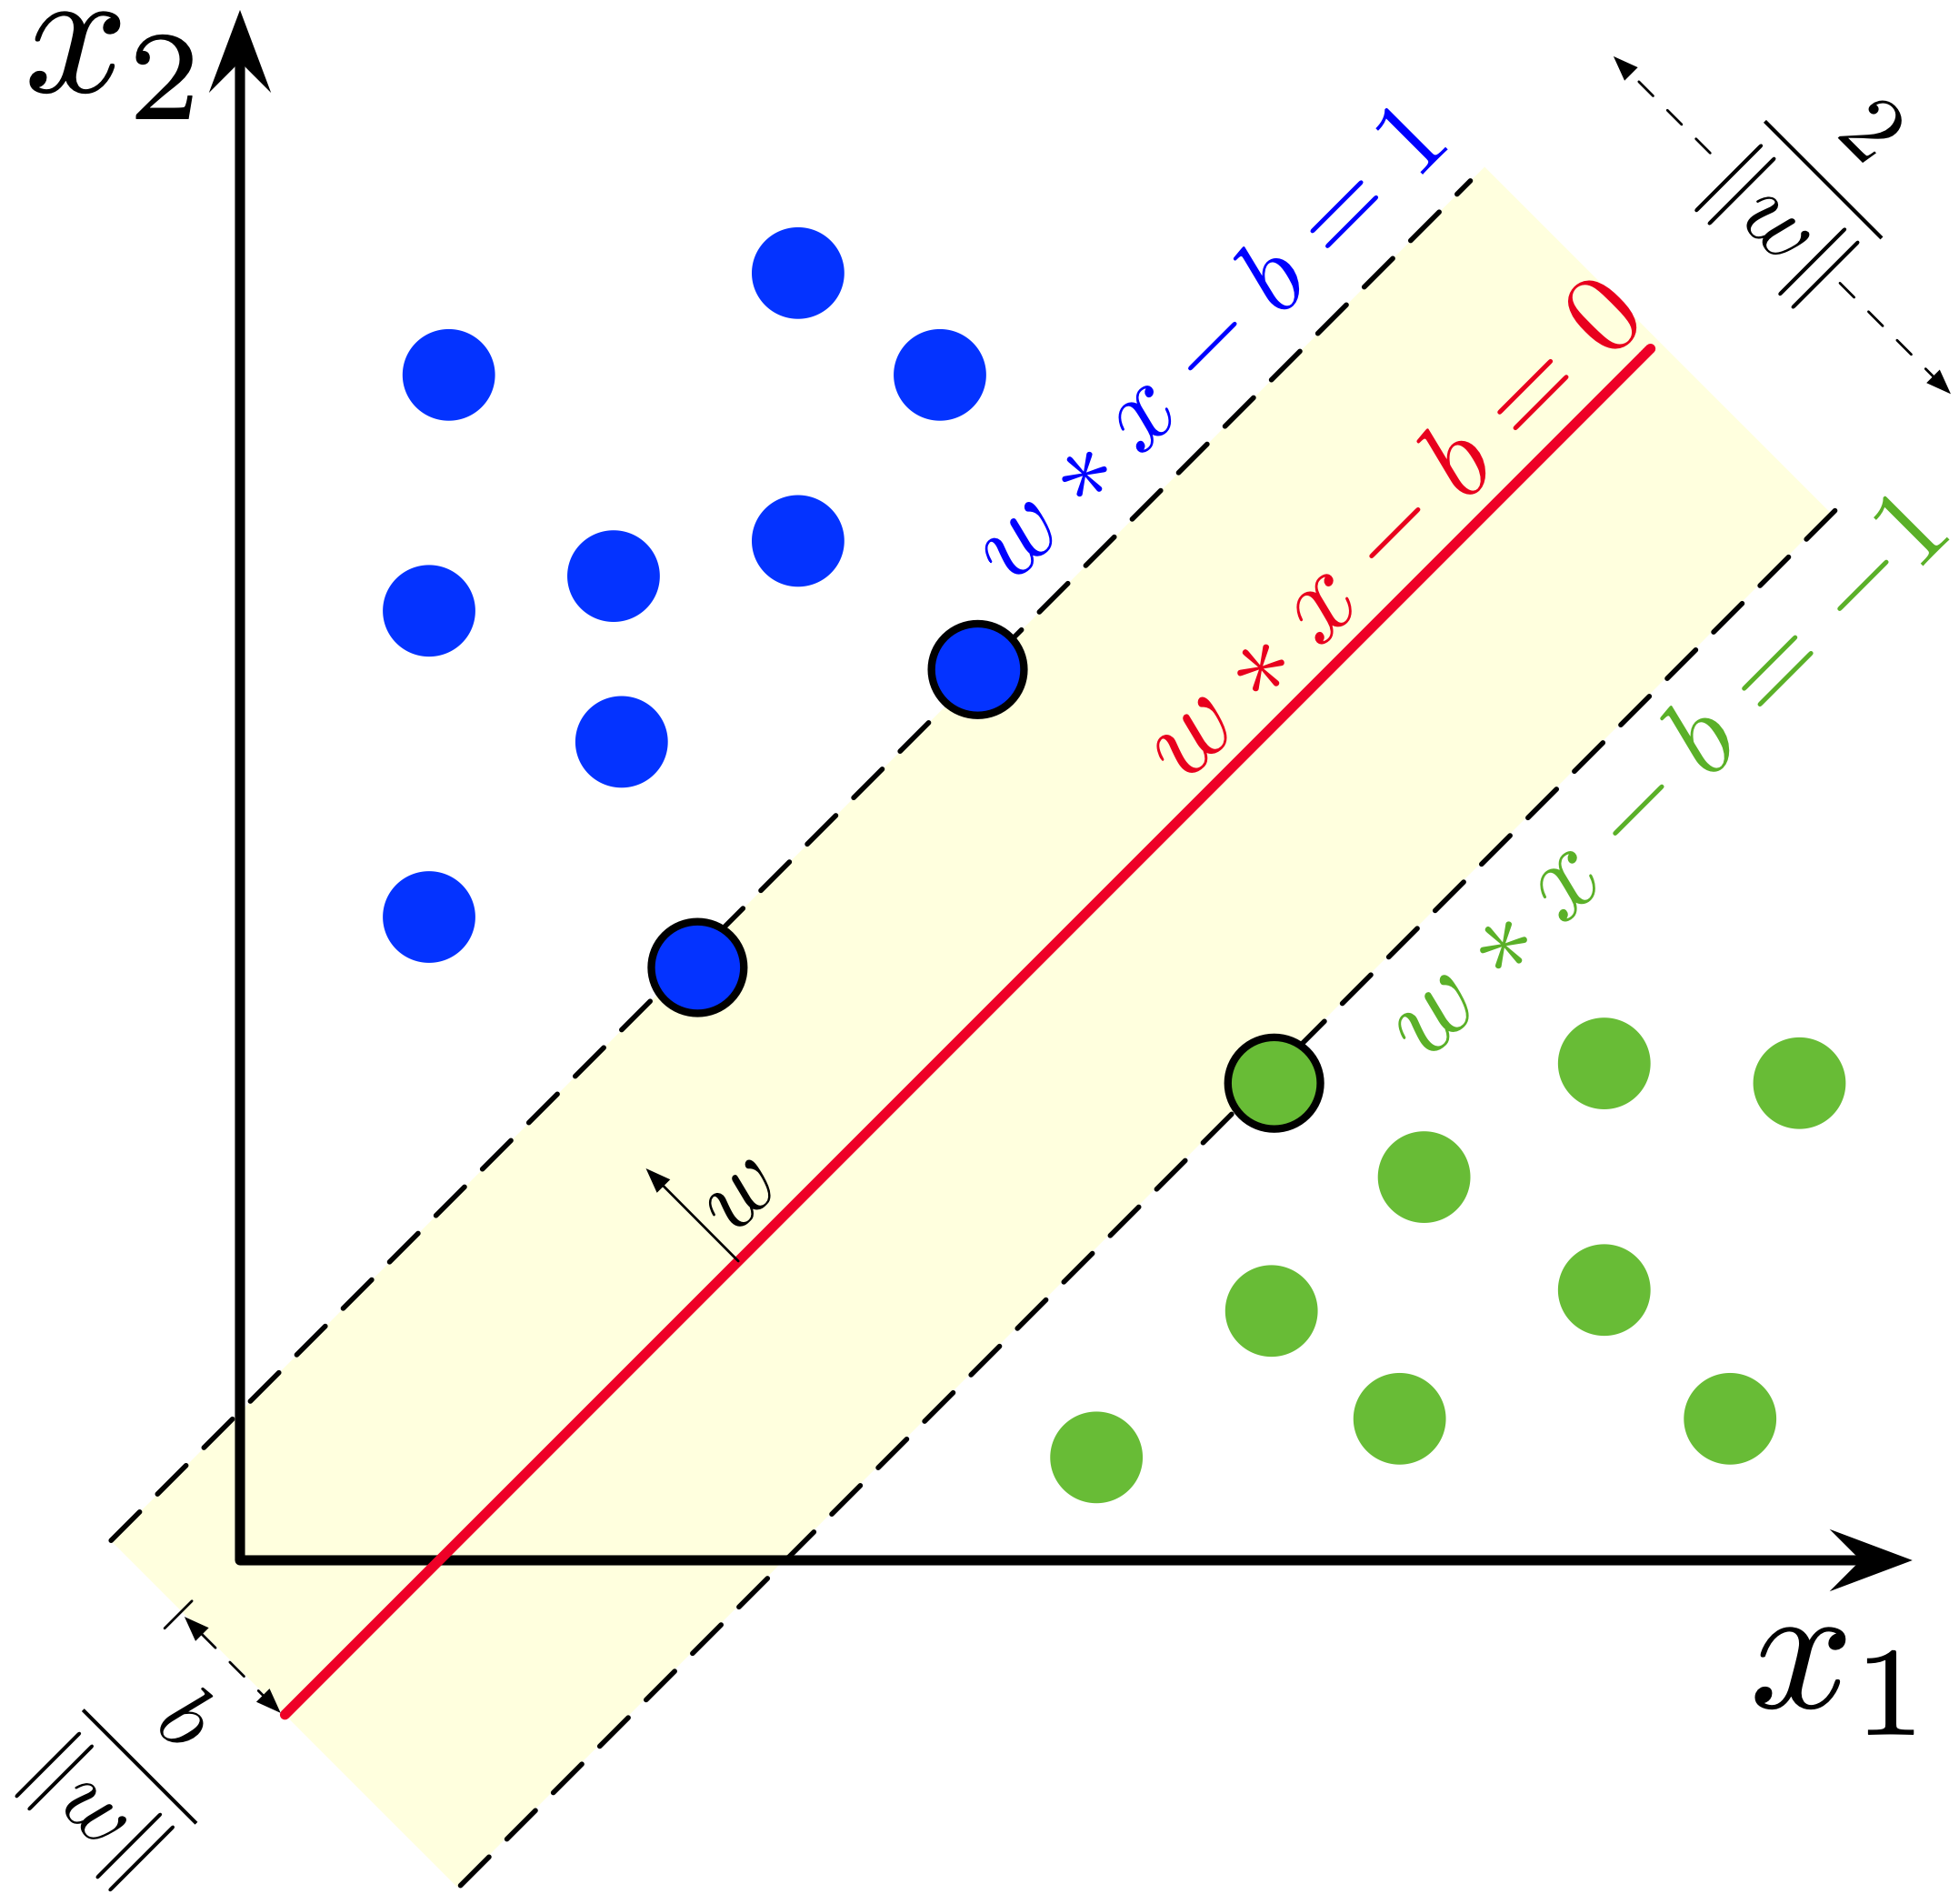

In fact, in the rescaled space, we can compute the margin as the sum of the distance from the plane of the closest positively-labeled point (denote it $x^+$) and the distance from the plane of the closest negatively-labeled point (denote it $x^-$). We also know that the points $x^+$ and $x^-$ satisfy $\langle w, x^{\pm} \rangle + b = \pm 1$, thanks to the rescaling.

The margin is therefore: 

$$\frac{1}{\|w\|}|\langle w, x^+ \rangle + b| + \frac{1}{\|w\|}|\langle w, x^- \rangle + b| = \frac{2}{\|w\|}$$

where we have used the formula for the distance of a point from a plane.

In the rescaled space, we can therefore maximize the margin by minimizing the norm of the vector $w$. In other words, we found the following equivalent problem:

$$ \text{Solve} \quad (\tilde{w}, \tilde{b}) = \underset{(w,b)}{\text{argmin}} \left\|w\right\|^2 \quad \quad \text{subject to} \quad y_i(\langle w, x_i \rangle + b) \ge 1, \: \forall i \in [n]$$

$$ \text{Return} \quad (\hat{w}, \hat{b}) = \left(\frac{\tilde{w}}{\left\|\tilde{w}\right\|}, \frac{\tilde{b}}{\left\|\tilde{w}\right\|}\right) $$

This algo can be solved using quadratic programming (i.e. optimization of quadratic forms subject to linear constraints). But we will solve it approximately by solving a more general problem, which is the generalization of the hard-margin SVM to datasets that are not linearly separable.

## Soft-margin SVM: theory

Both the perceptron algorithm and the hard-margin SVM apply exclusively to the case in which the dataset is linearly separable. Of course for real-world applications, this assumption is too restrictive.

We can solve this problem by introducing a soft-margin, that is a margin that can be violated. 

$$ \text{Solve} \quad \underset{w,b, \xi_i}{\text{argmin}} \:\: \frac{\lambda}{2} \left\|w\right\|^2 + \frac{1}{n} \sum_{i=1}^n \xi_i$$ 

$$\text{subject to} \quad y_i(\langle w, x_i \rangle + b) \ge 1 - \xi_i \:\: \text{and} \:\: \xi_i \ge 0, \:\: \: \forall i \in [n]$$

The variables $(\xi_i)$ are proportional to the distance of a point from its correct margin and the variable $\lambda$ quantifies that tradeoff between classification errors and margin maximization.

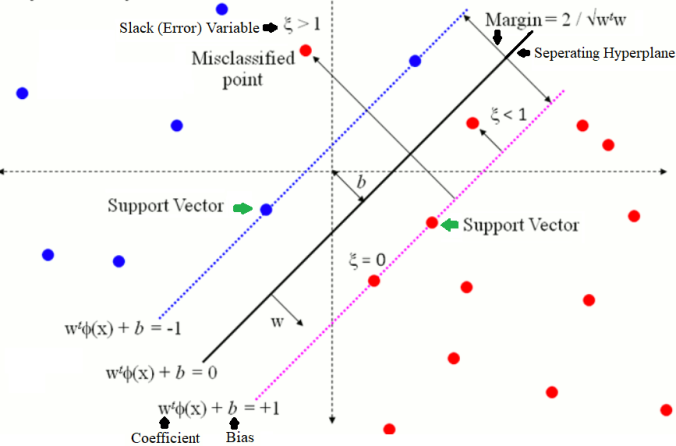

If our dataset is linearly separable, then for small values of $\lambda$ the model approximately behaves like a hard-margin SVM.

Most SVM implementations solve this constrained optimization problem by solving numerically the Langragian dual problem, which is again a constrained optimization problem, but slightly easier to solve.

## Soft-margin SVM: implementation

Our approach in this class will be to rewrite the soft-margin SVM optimization problem as a Regularized Loss Minimization (RLM) problem by defining a hinge loss function:

$$ \underset{w,b}{\text{argmin}} \:\: \frac{\lambda}{2} \left\|w\right\|^2 + L_S(w,b),$$ 

where $ l(w,b, (x,y)) = \max \{0, 1 - y(\langle w, x \rangle + b)\} \quad \text{and} \quad L_S(w,b) = \frac{1}{n} \sum_{i=1}^n l(w,b, (x_i,y_i))$.

The $\frac{\lambda}{2} \left\|w\right\|^2$ term is called the margin term, because it is related to margin maximization, while the $L_S(w,b)$ term is called the error term, because it penalizes misclassification.

This problem can be easily shown to be equivalent to the classical soft-margin SVM problem we saw before, and it can be solved using Stochastic Gradient Descent (SGD), with the help of subgradients.

### Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent is a numerical method for the optimization of a function, say $f$, similar to Gradient Descent.

Unlike Gradient Descent we don't update our variable in the direction of the gradient, $\nabla f$, which might be expensive or impossible to compute. 

In SGD we update our variable in a random direction and we only impose that this random direction must be an unbiased estimate of the gradient, i.e. that its expectation is equal to the gradient.

The update step is therefore:

$$ w^{(t+1)} = w^{(t)} - \eta \nu^{(t)},$$

where $\mathbb{E}[\nu^{(t)}|w^{(t)}] = \nabla f(w^{(t)})$.

SGD is particularly useful in the case of risk minimization problems, because it allows us to minimize directly the true loss (or true risk). Let's see how this is done.

**Reminder:** Recall that in Machine Learning we want to minimize the true loss of our model. If our model is parametrized by a vector of coefficients, $w \in \mathbb{R}^d$ (as in the case, for example, of linear regression), then this means that we want to minimize $L(w) = \mathbb{E}_{(x,y) \sim \mathcal{D}}[l(w,(x,y)]$, where $l$ is our loss-function (for example, the l2 loss). Typically this is impossible to do because the true loss depends on the true, unknown distribution of the sample points and the standard approach is therefore to minimize the empirical risk, $L_S(w) = \frac{1}{n} \sum_{i=1}^n l(w, (x_i,y_i))$, on our training dataset, hoping that this Empirical Risk Minimization strategy will allow us to pick models with low true risk.

With SGD we can directly minimize the true loss in the following way.

If $(x,y) \sim \mathcal{D}$ is a freshly sampled datapoint from the unknown, true distribution of the sample points, and we let $\nu^{(t)} = \nabla l(w^{(t)}, (x,y))$, then we have that its expectation satisfies:

$$ \mathbb{E}[\nu^{(t)}|w^{(t)}] =  \mathbb{E}[\nabla l(w^{(t)}, (x,y))|w^{(t)}] = \nabla \mathbb{E}[l(w^{(t)}, (x,y))] = \nabla L(w^{(t)}) $$

Therefore we can use $\nu^{(t)} = \nabla l(w^{(t)}, (x,y))$ computed on a freshly sampled $(x,y)$ has the random direction to use in the update step of our SGD algorithm.

Of course, typically we cannot extract new datapoints from the unknown distribution, but assuming that the points in our training dataset are iid realizations of this unknown distribution, then we can use them iteratively, one by one (and several times over), to compute $\nu^{(t)} = \nabla l(w^{(t)}, (x,y))$ as an unbiased estimate of the gradient of the true loss.

### Sub-gradients

Using SGD we can finally tackle the true loss minimization for our problem, which means that we want to minimize the regularized true loss function given by:

$$ \frac{\lambda}{2} \left\|w\right\|^2 + \frac{1}{n} \sum_{i=1}^n l(w,b, (x_i,y_i)),$$

where $l(w,b, (x,y)) = \max \{0, 1 - y(\langle w, x \rangle + b)\}$.

In order to use SGD we need to compute the gradient of our objective function, which is $\lambda w + \nabla l(w^{(t)}, (x,y))$. Unfortunately this function is not well defined, because $l(w^{(t)}, (x,y))$ is not everywhere differentiable, but we can overcome this problem by using subgradients, instead of gradients.

Recall that for a differentiable, convex function we have

$$ f(u) \ge f(w) + \langle u- w, \nabla f(w) \rangle.$$

For a non-differentiable, convex function, we define a vector, $v$, to be a subgradient of $f$ at $w$ if it satisfies:

$$ f(u) \ge f(w) + \langle u- w, v \rangle.$$

This means in practice that at any point $w$ of non-differentiability of a convex function, $f$, we can always define a sub-gradient, $v \in \partial f(w)$, such that this vector lies entirely below the graph of $f$. 

This sub-gradient is in general not unique, but it is always well defined for convex functions.

For our function $l(w,b, (x,y)) = \max \{0, 1 - y(\langle w, x \rangle + b)\}$, we just pick as sub-gradient $\nu^{(t)} \in \partial l(w^{(t)}, (x,y))$ the following:

$\nu^{(t)} = \begin{cases} -y x, & \text{if $y(\langle w, x \rangle + b) < 1$}, \\ 0, & \text{otherwise,} \end{cases}$ 

which is equivalent to setting the gradient to zero at the point of non-differentiability.

## Soft-margin SVM: the algorithm

Summing up everything we said so far, at the update step of our SGD we extract randomly from our training dataset a sample point, $(x_i, y_i)$ and compute:

$$ w^{(t+1)} = w^{(t)} - \eta (\lambda w^{(t)} + \nu^{(t)}) = \begin{cases} w^{(t)} - \eta (\lambda w^{(t)} -y_i x_i), & \text{if $y_i(\langle w, x_i \rangle + b) < 1$}, \\ w^{(t)} - \eta \lambda w^{(t)}, & \text{otherwise.} \end{cases}$$

There are several ways of improving the performance of SGD. 

One way of doing this is by picking a learning rate $\eta$ that decreases in time, which allows us to make smaller and smaller steps as we get closer to the point of minimum.

Furthermore our problem can be shown to be $\lambda$-strongly convex, therefore an additional improvement can be gained by setting $\eta = \frac{1}{\lambda t}$.

Due to the stochastic nature of SGD, it is not recommended to return the last value of $w$ found, that is $w^{(T)}$. Instead it is recommended to return, for example, the average value of $w$ along the exploration path $(w^{(1)}, w^{(2)}, \ldots, w^{(T)})$, or the value of $w$ along the path that yields the minimal empirical loss, since both these estimates are more robust.

The code we will implement is as follows:

$\quad \quad \quad$ **Soft-margin SVM**:

**Input**: Training dataset $(x_1, y_1), \ldots, (x_n, y_n)$.

**Initialize**: $w^{(1)} = (0, \ldots, 0)$.

**for** $t = 1, 2, 3, \ldots, T$:

$\quad$ Choose $i$ uniformly at random from $\{1, 2, \ldots, n\}$.

$\quad$ **if** $\:\: y_i\langle w, x_i \rangle < 1$:

$\quad \quad$ $w^{(t+1)} = w^{(t)} - \frac{1}{\lambda t} (\lambda w^{(t)} - y_i x_i)$

$\quad$ **else**:

$\quad \quad$ $w^{(t+1)} = w^{(t)} - \frac{1}{\lambda t} (\lambda w^{(t)}).$

**return**: $ w = \underset{t = 1, \ldots, T}{\text{argmin}} \:\: \frac{\lambda}{2} \left\|w^{(t)}\right\|^2 + L_S(w^{(t)},b)$

## Soft-margin SVM: examples

Let's see first of all, in the linearly separable case, how a soft-margin SVM with big $\lambda$ results in a larger margin separator, as opposed to a soft-margin SVM with low $\lambda$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

x, y = datasets.make_blobs(n_samples=200, centers=[[10,10],[12,12]], n_features=2, cluster_std=0.5, random_state=2)

y = 2*y-1

plt.scatter(x[:,0], x[:,1], c=y)
plt.show()

In [ ]:
def risk(x, y, l, w):
    n, d = x.shape
    margin_term = 0.5*l*(np.linalg.norm(w)**2)
    error_term = np.mean(np.maximum(np.zeros(n), 1 - y.dot(x.dot(w))))
    
    return margin_term + error_term

def svm_soft_train(x, y, l=1.0, verbose=False, max_iter = 10**4):        
       
    def addones(x):
        column_of_ones = np.ones((x.shape[0],1))
        output = np.hstack((column_of_ones,x))
        return output
    
    # Standardize data and add column of ones
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x = addones((x - x_mean)/x_std)
    
    n, d = x.shape
    w = np.zeros(d)
    risk_old = 0.
    risk_new = risk(x, y, l, w)
    best_w = np.zeros(d)
    
    i = 1
    while i < max_iter:
        if verbose:
            print(i)
            print(risk_new)        

        random_index = np.random.randint(0, n)
        
        if y[random_index]*(x[random_index, :].dot(w)) < 1:
            subgradient = l*w - y[random_index]*x[random_index,:]
            w = w - (1/(l*i))*(subgradient)
        else:
            subgradient = l*w
            w = w - (1/(l*i))*(subgradient)
        
        risk_new, risk_old = risk(x, y, l, w), risk_new
        
        if risk_new < risk_old:
            best_w = w
        
        i = i + 1
    if verbose:
        print("Iterations: ", i)
        
    w = best_w
    
    # Compute the w for the non-standardized data    
    w[1:] = w[1:]/x_std
    w[0] = w[0] - w[1:].dot(x_mean)
    
    return w

In [ ]:
t = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 10)

plt.scatter(x[:,0], x[:,1], c=y)

# High lambda line: tries to find a large margin, cares less about misclassification
w = svm_soft_train(x, y, l=0.1)
plt.plot(t, -(w[1]/w[2])*t-(w[0]/w[2]), 'b')
plt.plot(t, -(w[1]/w[2])*t-((w[0]-1)/w[2]), 'b--')
plt.plot(t, -(w[1]/w[2])*t-((w[0]+1)/w[2]), 'b--')

# High lambda line: tries to reduce misclassification as much as possible, big margin not so important
w = svm_soft_train(x, y, l=0.00001)
plt.plot(t, -(w[1]/w[2])*t-(w[0]/w[2]), 'r')
plt.plot(t, -(w[1]/w[2])*t-((w[0]-1)/w[2]), 'r--')
plt.plot(t, -(w[1]/w[2])*t-((w[0]+1)/w[2]), 'r--')

plt.ylim(np.min(x[:,1]), np.max(x[:,1]))
plt.show()

Notice how the low $\lambda$ SVM is more interested in correctly classifying all points, including the two blue outliers on the right. The high $\lambda$ SVM, instead, selects a line with a bigger margin, which results in the misclassification of the two blue outliers, but also in a much better generalization.

The parameter $\lambda$ is usually fixed via cross-validation.

In [ ]:
# Compare high-lambda (= low C) and low lambda (= high C) behavior on sklearn LinearSVC

from sklearn.svm import LinearSVC

t = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 10)

plt.scatter(x[:,0], x[:,1], c=y)

clf = LinearSVC(tol=1e-6, dual=False, C=10**(6))
clf.fit(x, y)
w = np.hstack((clf.intercept_[0], clf.coef_[0]))
plt.plot(t, -(w[1]/w[2])*t-(w[0]/w[2]), 'r')
plt.plot(t, -(w[1]/w[2])*t-((w[0]-1)/w[2]), 'r--')
plt.plot(t, -(w[1]/w[2])*t-((w[0]+1)/w[2]), 'r--')

clf = LinearSVC(tol=1e-6, dual=False, C=10)
clf.fit(x, y)
w = np.hstack((clf.intercept_[0], clf.coef_[0]))
plt.plot(t, -(w[1]/w[2])*t-(w[0]/w[2]), 'b')
plt.plot(t, -(w[1]/w[2])*t-((w[0]-1)/w[2]), 'b--')
plt.plot(t, -(w[1]/w[2])*t-((w[0]+1)/w[2]), 'b--')

plt.ylim(np.min(x[:,1]), np.max(x[:,1]))
plt.show()

# Practice yourself!

1. Implement a routine to find the optimal value of $\lambda$ (or $C$, if you use the scikit learn implementation) via cross-validation.
2. Fit a SVM model to the Titanic dataset or the [breast cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) provided by the sklearn package, and compare the performance of SVM with the performance of logistic regression and decision trees.
3. Use Stochastic Gradient Descent (instead of Gradient Descent) in our numerical implementation of linear regression and test it on an artificial dataset. Which one is faster for large sample sizes? And for many features?
4. Implement Lasso (linear regression with $L_2$ error + $L_1$-norm regularization) using subgradients. Or implement a linear regression with $L_1$ error function, instead of ordinary least squares, using subgradients.